In [1]:
from fastai.vision import *
from skimage.io import imread
%run losses.ipynb
%run Seg_dl.ipynb

from tqdm import tqdm

In [2]:
p = Path('./Lea/190819')
pad = (p/'DAPI').ls()

In [3]:
pad[0].suffix

'.TIF'

In [4]:
get_y_fn = lambda x: p/'masks'/f'{x.stem[:-2]}w2'
get_t_fn = lambda x: p/'Trans'/f'{x.stem[:-2]}w4.TIF'

In [5]:
def convert_to_float(x):
    if x.dtype == 'uint16':
        x = np.asarray(x/2**16, dtype = np.float32)
    else:
        x = np.asarray(x/1, dtype = np.float32)
    return x

In [6]:
def crop_16(x):
    ids = [0, 512, 1024, 1536]
    xs = np.zeros((16,512,512), dtype = np.float32)
    for i in range(4):
        for j in range(4):
            xs[i*4+j] = x[ids[i]:ids[i]+512, ids[j]:ids[j]+512]
    return xs 

In [7]:
defaults.device = torch.device('cuda')

In [8]:
learn = load_learner('Lea/190819/DAPI')

In [9]:
norm = ([0.0262,0.23333],[0.0429,0.00634]) #mean(dapi, trans), stdev(dapi, trans)

In [42]:
class DapiTransFull(Dataset):
    def __init__(self, pth):
        self.pth = Path(pth)
        self.fn_list = []
        for f in Path(pth).iterdir():
            if f.suffix == '.TIF':
                self.fn_list.append(f)
        self.get_t_fn = lambda x: p/'Trans'/f'{x.stem[:-2]}w4.TIF'
    def __len__(self):
        return len(self.fn_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fn = self.fn_list[idx]
        im = imread(fn)
        im = convert_to_float(im)
        t_im = imread(self.get_t_fn(fn))
        t_im = convert_to_float(t_im)
        out = np.expand_dims(np.stack((im,t_im), axis = 0), axis = 0)
        out = tensor(out)
        return out.sub(tensor(norm[0])[None,:,None,None]).div(tensor(norm[1])[None,:,None,None]).cuda()

In [43]:
ds = DapiTransFull(p/'DAPI')

In [38]:
class DapiTransDs(Dataset):
    def __init__(self, pth):
        self.pth = Path(pth)
        self.fn_list = []
        for f in Path(pth).iterdir():
            if f.suffix == '.TIF':
                self.fn_list.append(f)
        self.get_t_fn = lambda x: p/'Trans'/f'{x.stem[:-2]}w4.TIF'
    def __len__(self):
        return len(self.fn_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        fn = self.fn_list[idx]
        im = imread(fn)
        im = convert_to_float(im)
        t_im = imread(self.get_t_fn(fn))
        t_im = convert_to_float(t_im)
        crop_d = crop_16(im)
        crop_t = crop_16(t_im)
        stck = tensor(np.stack((crop_d, crop_t), axis = 1))
        return stck.sub(tensor(norm[0])[None,:,None,None]).div(tensor(norm[1])[None,:,None,None]).cuda()


In [39]:
ds2 = DapiTransDs(p/'DAPI')

In [13]:
learn.model.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [44]:
# This runs one full size image through the NN
outs = []
for f in tqdm(range(8)):
    with torch.no_grad():
        out = learn.model(ds[f])
        out = torch.sigmoid(out)
        outs.append(out)
        torch.cuda.empty_cache()

100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


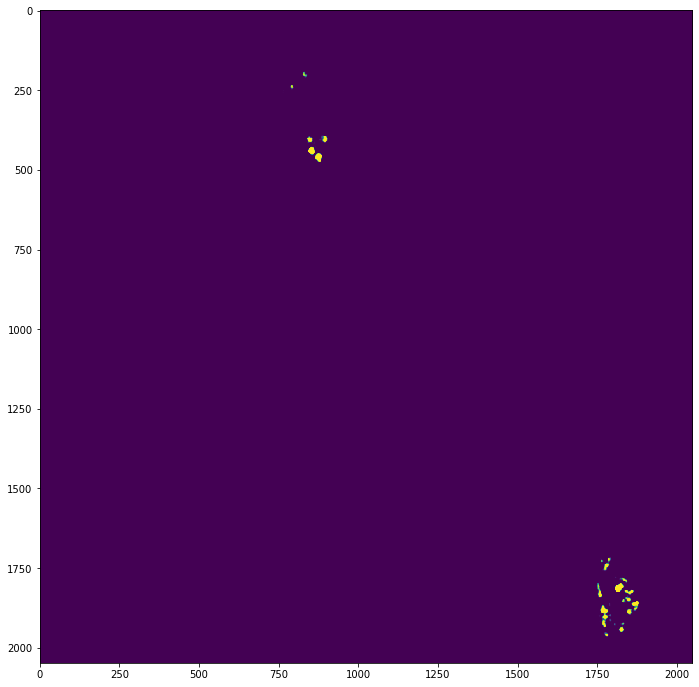

In [58]:
plt.figure(figsize=(12,12))
plt.imshow(outs[7][0][0])

In [49]:
# This cuts one image up into 16 pieces before going into the NN, and pastes it back together after
outs2 = []
for f in tqdm(range(8)):
    with torch.no_grad():
        out = learn.model(ds2[f])
        out = torch.sigmoid(out)

        a = out.view(16,512,512)

        b = torch.cat((a[0],a[4],a[8],a[12]))

        for i in range(1,4): 
            c = torch.cat((a[i],a[i+4],a[i+8],a[i+12]))
            b = torch.cat((b,c), dim = 1)
        outs2.append(b)
        torch.cuda.empty_cache()

100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


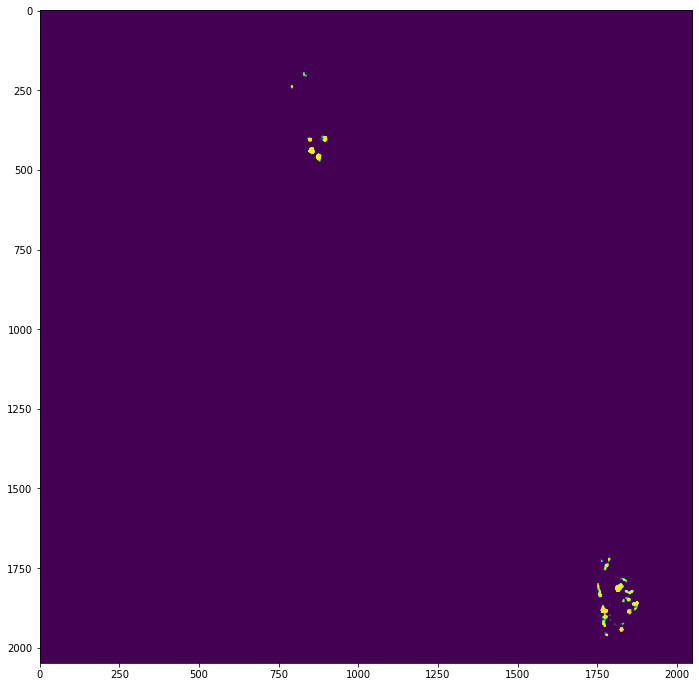

In [59]:
plt.figure(figsize=(12,12))
# plt.imshow(im)
plt.imshow(outs2[7])

### There is basically no difference if you cut the images up or not